<a href="https://colab.research.google.com/github/williazo/microbiomeDASim/blob/devbranch/inst/script/mvrnorm_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Microbiome Data from Multivariate Normal Distribution

Below, we demonstrate how to simulate longitudinal differential abundance for microbiome normalized counts generated from 16S rRNA sequencing in order to compare different methodologies for estimating this differential abundance. Simulating microbiome data presents a variety of different challenges based both on biological and technical challenges. 

These challenges include:
1. Non-negative restriction
1. Presence of Missing Data/High Number of Zero Reads
2. Low Number of Repeated Measurements
3. Small Number of Subjects

For our initial simulation design, we are attempting to address many of these challanges by simulating data across a variety of different parameter scenarios where each element of the challenges listed above can be investigated. Since many of the methods when analyzing microbiome data involve normalization procedures and the central limit theory allows us to think about the normal distribution as an asymptotic ideal, we will treat the Multivariate Normal Distribution as our best case scenario for simulation purposes.

## Statistical Methodology
Assume that we have data generated from the following distribution,
$$\mathbf{Y}\sim N(\mathbf{\mu}, \mathbf{\Sigma})$$

where
$$\mathbf{Y}=\begin{pmatrix}
\mathbf{Y}_{1}^{T} \\
\mathbf{Y}_{2}^{T} \\
\vdots \\
\mathbf{Y}_{n}^{T}
\end{pmatrix}=\begin{pmatrix}
Y_{11} \\
Y_{12} \\
\vdots \\
Y_{1q_{1}}\\
Y_{21} \\
\vdots \\
Y_{2q_{2}}\\
\vdots \\
Y_{nq_{n}}
\end{pmatrix}$$ with $Y_{ij}$ representing the $i^{th}$ patient at the $j^{th}$ timepoint where each patient has $q_{i}$ repeated measurements with $i\in\{1,\dots,n\}$ and $j\in\{1,\dots,q_{i}\}$. We define the total number of observations as $N=\sum_{i=1}^{n}q_{i}$. Therefore in our original assumption defined above we can explicitly define the dimension of our objects as

$$\mathbf{Y}_{N\times 1}\sim N_{N}(\mathbf{\mu}_{N\times 1}, \mathbf{\Sigma}_{N\times N})$$

In our current simulations we choose to keep the number of repeated measurements constant, i.e., $q_{i}=q \ \forall \ i\in\{1,\dots,n\}$. This means that the total number of obseravtions simplifies to the expression $N=qn$. However, we will vary the value of $q$ across the simulations to simulate data generated from a study with a small ($q=3$), medium ($q=6$), or large ($q=12$) number of repeated observations. Currently most studies with microbiome data collected fall closest to the small case, but there are a few publically available datasets that contain a large number of repeated observations for each individual. For simplicity in the remaining description of the methodology we will assume constant number of repeated observations.

Without loss of generality we can split the total patients ($n$) into two groups, control ($n_{0}$) vs ($n_{1}$), with the first $n_{0}$ patients representing the control patients and the remaining $n-n_{0}$ representing the treatment. Partitioning our observations in this way allows us to also partition the mean vector as $\mathbf{\mu}=(\mathbf{\mu}_{0}, \mathbf{\mu}_{1})$. In our current simulation shown below we assume that the mean for the control group is constant $\mu_{0}\mathbf{1}_{n_{0}\times 1}$, but we allow our mean vector for the treatment group to vary depending on time $\mu_{1ij}(t)=\mu_{0} + f(t_{j})$ for $i = 1,\dots, n_{1}$ and $j = 1,\dots,q$. In our simulation we will choose a parametric form for the function $f(t_{j})$ primarly from the polynomial family where 
$$f(t_{j})=\beta_{0}+\beta_{1}t_{j}+\beta_{2}t_{j}^{2}+\dots+\beta_{p}t_{j}^{p}$$
for a $p$ dimensional polynomial. For instance, to define a linear polynomial we would have 
$$f(t_{j})=\beta_{0}+\beta_{1}t_{j}$$
where $\beta_{1}>0$ for an increasing linear trend and $\beta_{1}<0$ for a decreasing linear trend. For a list of available functional forms currently implemented and the expected form of the input see documentation for `microbiomeDASim::mean_trend`.

For the covariance matrix, we want to encode our longitudinal dependencies so that observations within an individual are correlated, i.e., $\text{Cor}(Y_{ij}, Y_{ij'})\ne0$, but that observations between individuals are independent, i.e., $\text{Cor}(Y_{ij}, Y_{i'j})=0 \ \forall i\ne i' \ \text{and} \ j$. To accomplish this we define the matrix $\mathbf{\Sigma}_{N\times N}$ as $\mathbf{\Sigma}=\text{bdiag}(\mathbf{\Sigma}_{1},\dots,\mathbf{\Sigma}_{n})$, where each $\mathbf{\Sigma}_{i}$ is a $q\times q$ matrix a specific longitudinal structure.

For instance if we want to specify an autoregressive correlation structure for individual $i$ we could define their covariance matrix as
$$\mathbf{\Sigma}_{i}=\sigma^{2}\begin{bmatrix}
1 & \rho & \rho^{2} & \cdots & \rho^{|1 - q|} \\
\rho & 1 & \rho & \cdots & \rho^{|2-q|} \\
\rho^{2} & \rho & 1 & \cdots & \\
\vdots &  & & \ddots & \vdots \\
\rho^{|q-1|} & \rho^{|q-2|} & \cdots & \cdots & 1
\end{bmatrix}$$
In this case we are using the first order autoregressive definition and therefore will refer to this as "ar1".

Alternatively, for the compound correlation structure for an individual $i'$ we could define the covariance matrix as
$$\mathbf{\Sigma}_{i'}=\sigma^{2}\begin{bmatrix}
1 & \rho & \rho & \cdots & \rho \\
\rho & 1 & \rho & \cdots & \rho \\
\rho & \rho & 1 & \cdots & \\
\vdots &  & & \ddots & \vdots \\
\rho & \rho & \cdots & \cdots & 1
\end{bmatrix}$$

Finally, the independent correlation structure for an individual $i''$ would be defined as
$$\mathbf{\Sigma}_{i''}=\sigma^{2}\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
0 & 0 & 1 & \cdots & \\
\vdots &  & & \ddots & \vdots \\
0 & 0 & \cdots & \cdots & 1
\end{bmatrix}$$

#### Trivial Example
We can construct a trivial example where $n=2$ ($n_0=1$ and $n_{1}=1$) and $q=2$, an ar1 correlation structure where $\rho = 0.8$, $sigma=1$, a linear functional form with $\mathbf{\beta}=(0, 1)^{T}$, control mean is constant at $\mu_{0}=2$ and $t=(1, 2)$. 
$$Y\sim\text{N}_{4}\begin{pmatrix}
\begin{pmatrix}
\mu_{0} \\
\mu_{0} \\
\mu_{0} +  \beta_0 + \beta_1\times t_{1}\\
\mu_{0} +  \beta_0 + \beta_1\times t_{2}
\end{pmatrix},\sigma^{2}
\begin{pmatrix}
1 & \rho & 0 & 0 \\
\rho & 1 & 0 & 0 \\
0 & 0 & 1 & \rho \\
0 & 0 & \rho & 1
\end{pmatrix}
\end{pmatrix}=
\text{N}_{4}\begin{pmatrix}
\begin{pmatrix}
2 \\
2 \\
3 \\
4
\end{pmatrix},
\begin{pmatrix}
1 & 0.8 & 0 & 0 \\
0.8 & 1 & 0 & 0 \\
0 & 0 & 1 & 0.8 \\
0 & 0 & 0.8 & 1
\end{pmatrix}
\end{pmatrix}
$$

Below we show how to generate data in the package `microbiomeDASim` with these specifications.


In [0]:
#loading all of the packages we will use for analysis in this notebook
rm(list = ls()) #clearing the environment
#installing Bioconductor
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")

#installing microbiome specific packages from bioconductor
.list_of_conductor_packages <- c("metagenomeSeq")
#installing bioconductor specific packages
.inst <- .list_of_conductor_packages %in% installed.packages()
if(any(!.inst)){BiocManager::install(.list_of_conductor_packages[!.inst])}
#installing cran packages
.list_of_cran_packages <- c("devtools", "viridis", "tidyverse",
                            "gridExtra", "microbenchmark", "ggplot2")
.inst <- .list_of_cran_packages %in% installed.packages()
#installing cran specific packages
if(any(!.inst)) install.packages(.list_of_cran_packages[!.inst])
#GitHub specific directories
devtools::install_github("williazo/microbiomeDASim")

#loading/installing all of the needed packages
sapply(c(.list_of_conductor_packages, .list_of_cran_packages, "microbiomeDASim"),
       function(x) invisible(require(x, character.only = TRUE)))

Skipping install of 'microbiomeDASim' from a github remote, the SHA1 (01493503) has not changed since last install.
  Use `force = TRUE` to force installation


metagenomeSeq        devtools         viridis       tidyverse       gridExtra 
           TRUE            TRUE            TRUE            TRUE            TRUE 
 microbenchmark         ggplot2 microbiomeDASim 
           TRUE            TRUE            TRUE

In [0]:
#Trivial example described above
microbiomeDASim::mvrnorm_sim(n_control = 10, n_treat = 10, control_mean = 2, sigma = 1, num_timepoints = 2,
                             rho = 0.8, corr_str = "ar1", func_form = "linear", beta =  c(0, 1),
                             missing_pct = 0, missing_per_subject = 0)

$df
           Y ID time     group     Y_obs
1  3.1029196  1    1   Control 3.1029196
2  3.7519813  1    2   Control 3.7519813
3  2.6785489  2    1   Control 2.6785489
4  1.8443676  2    2   Control 1.8443676
5  2.3043303  3    1   Control 2.3043303
6  1.6039517  3    2   Control 1.6039517
7  2.8134720  4    1   Control 2.8134720
8  2.9052739  4    2   Control 2.9052739
9  4.0772268  5    1   Control 4.0772268
10 3.5306988  5    2   Control 3.5306988
11 2.9936933  6    1   Control 2.9936933
12 2.6386524  6    2   Control 2.6386524
13 3.0272250  7    1   Control 3.0272250
14 2.6272506  7    2   Control 2.6272506
15 0.8307995  8    1   Control 0.8307995
16 0.6293820  8    2   Control 0.6293820
17 3.9895987  9    1   Control 3.9895987
18 4.1312387  9    2   Control 4.1312387
19 0.4027386 10    1   Control 0.4027386
20 0.4831981 10    2   Control 0.4831981
21 2.7745082 11    1 Treatment 2.7745082
22 4.4479324 11    2 Treatment 4.4479324
23 2.8700378 12    1 Treatment 2.8700378
24 4.0318003

### Addressing Microbiome Specific Challanges during Simulation
In order to mimic the typical challanges associated with missing data for microbiome analyses, we systematically impute missingness into our data $\mathbf{Y}$.

## Implementation
One example for a non-trivial case where $n>2$ and $q>2$ for how to simulate this data is shown below

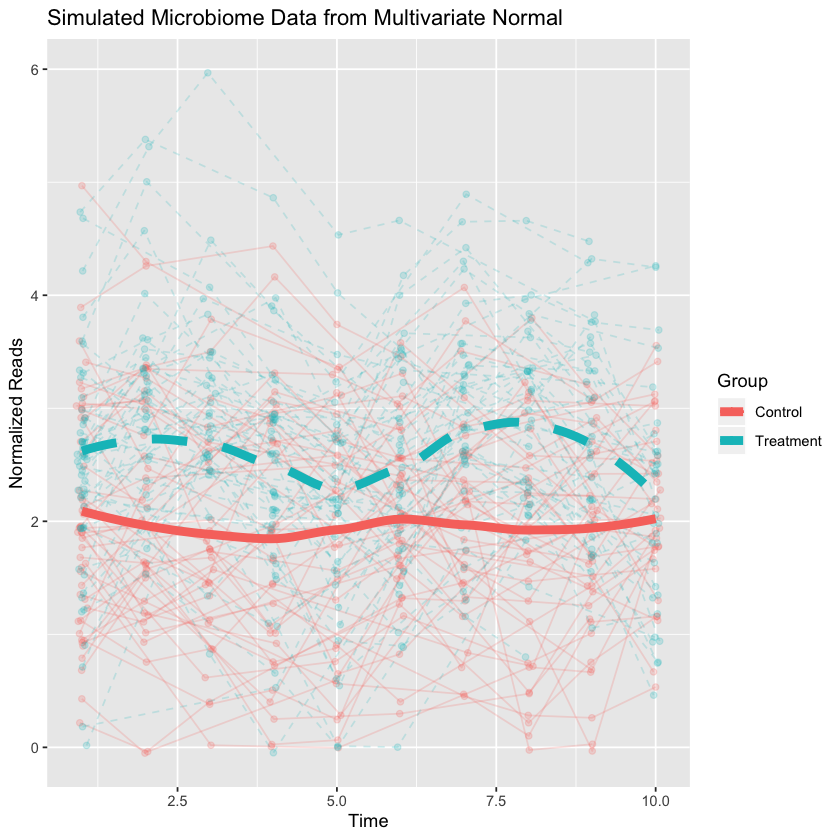

In [0]:
out_sim <- mvrnorm_sim(n_control = 50, n_treat = 50, control_mean = 2, sigma = 1, 
                       num_timepoints = 10, rho = 0.8, corr_str = "ar1",
                       func_form = "M", beta =  c(0, 0.5), IP = 10 * c(1/4, 2/4, 3/4),
                       missing_pct = 1, missing_per_subject = 3, dis_plot = TRUE)

Note that there are a variety of flexible choices for the the functional form of the trend:

+ Linear
+ Quadratic
+ Cubic
+ "M"/"W"

For example we now replace the linear trend with an "M" type pattern where we specify the initial intercept and slope and three change points where the slope will go from increasing to decreasing or vice versa. 

In [0]:
out_sim <- mvrnorm_sim(n_control = 30, n_treat = 30, control_mean = 2, sigma = 1,
                       num_timepoints = 10, rho = 0.8, corr_str = "compound",
                       func_form = "L_up", beta =  0.5, missing_pct = 1,
                       missing_per_subject = 2, IP = 5)

In our returned object we have the following objects saved as a list


In [0]:
names(out_sim)

[1] "df"        "Y"         "Mu"        "Sigma"     "N"         "miss_data"
[7] "Y_obs"

+ `df` = data.frame object with complete outcome ($Y$), subject ID, time, group, and outcome with missing data ($Y_{obs}$)
+ `Y` = vector of complete outcome
+ `Mu` = vector of complete mean specifications used during simulation
+ `Sigma` = block diagonal symmetric matrix of complete data used during simulation
+ `N` = total number of observations ($\sum_{i}^{n}q_{i}$)
+ `miss_data` = data.frame object that lists which ID's and timepoints were randomly selected to induce missingness
+ `Y_obs` = vector of outcome with induced missingness

We can observe the true functional form below.

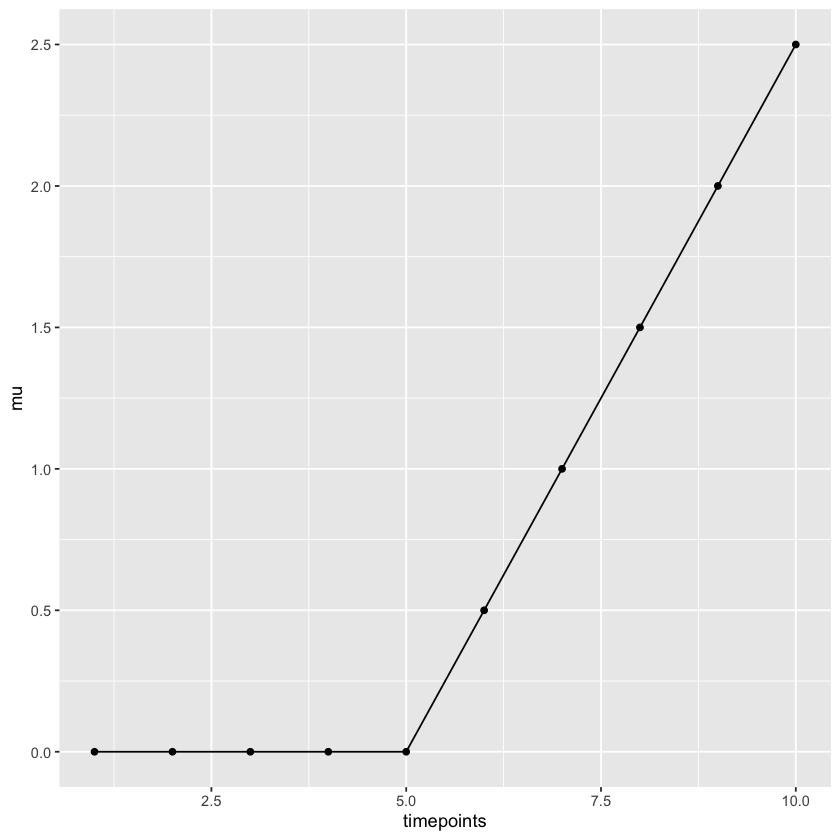

In [0]:
true_mean <- mean_trend(timepoints = 1:10, form = "L_up", beta = 0.5, IP = 5, plot_trend = TRUE)

The `mvrnorm_sim` method generates a single feature with a specified longitudinal differential abundance pattern. However, we may want to simulate a microboime environment with multiple features where certain features have differential abundance while others do not. 

To address this we can use the function `gen_microbiome`, which specifies the number of features and the number of differentiall abundant features. All features selected to have differential abundance will have the same type of functional form.

In [0]:
bug_gen <- gen_norm_microbiome(features=6, diff_abun_features=3, 
                               n_control=30, n_treat=20, control_mean=2, sigma=2,
                               num_timepoints=4, rho=0.9, corr_str="compound",
                               func_form="M", beta=c(4, 3), IP=c(2, 3.3, 6),
                               missing_pct=0.2, missing_per_subject=2,
                               miss_val=0)
head(bug_gen$bug_feat)
bug_gen$Y[, 1:5]
names(bug_gen)

Simulating Diff Bugs

Warning message:
“IP points outside of timepoint range”Warning message:
“IP points outside of timepoint range”Warning message:
“IP points outside of timepoint range”Simulating No-Diff Bugs



ID,time,group,Sample_ID
<int>,<int>,<chr>,<chr>
1,1,Control,Sample_1
1,2,Control,Sample_2
1,3,Control,Sample_3
1,4,Control,Sample_4
2,1,Control,Sample_5
2,2,Control,Sample_6


,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5
Diff_Bug1,0.000000,3.4694335,1.2143670,4.0492841,1.262285
Diff_Bug2,6.081131,4.9549813,4.6242889,0.0000000,3.935362
Diff_Bug3,0.000000,0.0000000,0.0000000,0.0000000,5.356267
NoDiffBug_1,3.409059,1.9240909,0.2222133,1.7340485,0.000000
NoDiffBug_2,0.000000,0.8213413,0.2926045,0.0000000,3.971192
NoDiffBug_3,1.912522,0.3082341,2.0729557,0.7355964,4.672982


[1] "Y"        "bug_feat"

Note that we now have two objects returned in this function. 

+ `Y` is our observed feature matrix with rows representing features and columns indicating our repeated samples
+ `bug_feat` identifies the subject ID, time, group (Control vs. Treatment) and corresponding Sample ID from the columns of `Y`.

We can graph the corresponding bugs below.

Skipping install of 'ggplot.spaghetti' from a github remote, the SHA1 (f8f022c3) has not changed since last install.
  Use `force = TRUE` to force installation


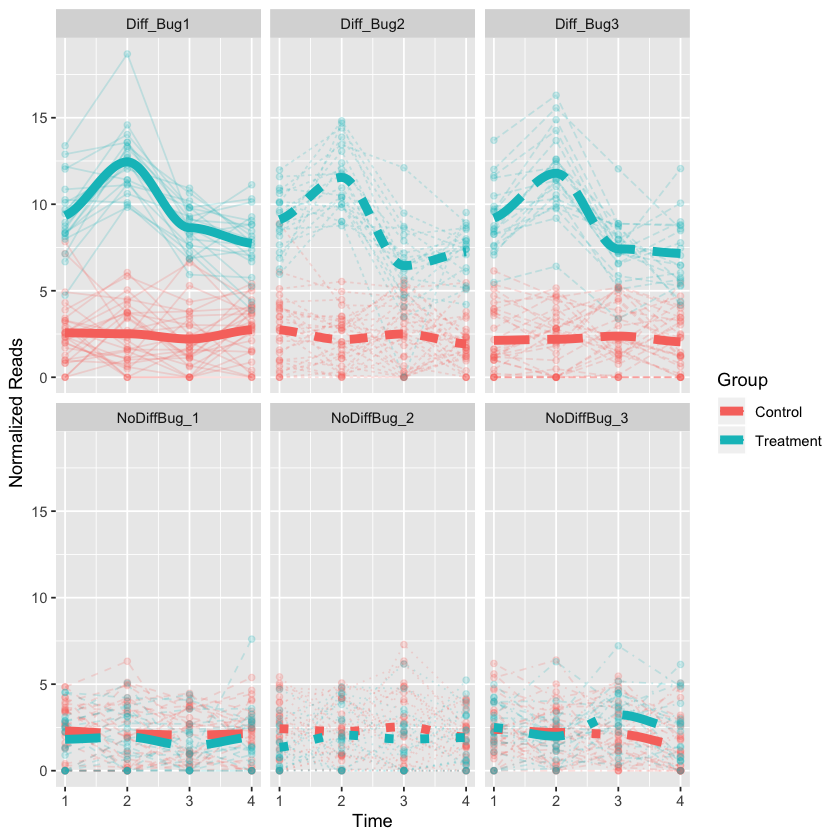

In [0]:
#faceted plot of bugs
install_github("williazo/ggplot.spaghetti")
long_bug <- c(t(bug_gen$Y))
bug_df <- data.frame(Y = long_bug, bug_name = rep(row.names(bug_gen$Y), each = ncol(bug_gen$Y)),
                     bug_gen$bug_feat)
bug_plot <- suppressWarnings(with(bug_df, ggplot.spaghetti::ggplot_spaghetti(y=Y, id=ID, time=time, group=group, wrap=bug_name)))+
  scale_x_continuous(breaks=seq(1, 4, 1))+
  scale_color_discrete(name="Group")+
  ylab("Normalized Reads")+
  xlab("Time")+
  guides(linetype=FALSE)
suppressWarnings(plot(bug_plot))

## Model Fitting

Now that we have our simulated data with longitudinal differential abundance we want to estimate the functional form using the proposed methods. In our case we will consider three different longidutinal procedures:

+ metaSplines
    + Smoothing Spline ANOVA with Gausian Parametrization
+ MetaLonDa
    + Smoothing Spline ANOVA with Negative Binomial Parametrization
+ bootLong
    + Non-parametric Block Bootstrap procedure
    
#### Performance Metrics
In terms of continuous performance metrics we can the following options comparing our estimates for the differential abunance $\hat{f(\mathbf{t})}$ to the true value $f(\mathbf{t})$:
+ Cosine similarity: $\frac{\hat{f}(\mathbf{t})^{T}f(\mathbf{t})}{||\hat{f}(\mathbf{t})||\cdot ||f(\mathbf{t})||} \ \in [-1, 1]$
+ Euclidean distance: $||\hat{f}(\mathbf{t})-f(\mathbf{t})|| \ \in[0,\infty]$
+ Normalized Euclidean Distance: $\big|\big|\frac{\hat{f}(\mathbf{t})}{||\hat{f}(\mathbf{t})||}-\frac{f(\mathbf{t})}{||f(\mathbf{t})||}\big|\big| \ \in[0, 2]$

On the other hand, we can also look at a binary measurement of whether *ANY* differential abundance was detected in the estimation procedure and compare this to the truth (YES/NO). In this way we can obtain estimates for the sensitivity and specificity as shown in the table below.

|             &nbsp;             | Est. Differential Abundance  | Est. No Differential Abundance |
|--------------------------------|------------------------------|--------------------------------|
| True Differential Abundance    | True Positive                | False Negative                 |
| True No Differential Abundance | False Positive               | True Negative                  |

Sensitivity = $\frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}$

Specificity = $\frac{\text{True Negative}}{\text{True Negative} + \text{False Negative}}$


### metaSplines

In [0]:
#extraxting the sample information
p_dat <- out_sim$df[ , -grep("Y", names(out_sim$df))]
row.names(p_dat) <- paste0("Sample_", seq_len(nrow(out_sim$df)))

# MRexpriment object with the non-missing counts
mvrnorm_meta <- AnnotatedDataFrame(p_dat)
MR_mvrnorm <- newMRexperiment(count = t(out_sim$Y), phenoData = mvrnorm_meta)
MR_mvrnorm

#fitting the metaSplines model with random intercept
metasplines_mod <- fitTimeSeries(obj = MR_mvrnorm, formula = abundance ~ time*class, id = "ID",
                                 time = "time", class = "group", feature = 1,
                                 norm = FALSE, log = FALSE, B = 1, random = ~ 1|id)
 

MRexperiment (storageMode: environment)
assayData: 1 features, 600 samples 
  element names: counts 
protocolData: none
phenoData
  sampleNames: Sample_1 Sample_2 ... Sample_600 (600 total)
  varLabels: ID time group
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

Now we can see the estimates from this model and if there were any significant differential time intervals identified.

Interval start,Interval end,Area,p.value
6,10,5.946902,0.5


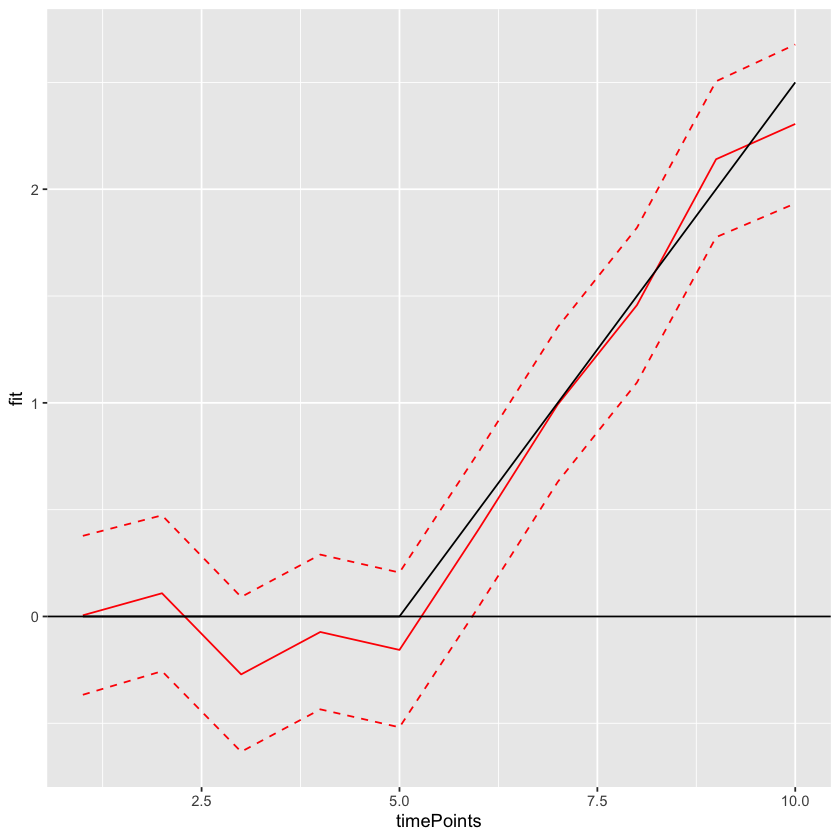

In [0]:
#areas where the time intervals were identified as significantly different
metasplines_mod$timeIntervals

gg_df <- data.frame(metasplines_mod$fit)
gg_df$lb <- gg_df$fit - 1.96*gg_df$se
gg_df$ub <- gg_df$fit + 1.96*gg_df$se
ggplot(data = gg_df, aes(x = timePoints, y = fit))+
  geom_line(col = "red")+
  geom_line(data = gg_df, aes(x = timePoints, y = lb), lty = 2, col = "red")+
  geom_line(data = gg_df, aes(x = timePoints, y = ub), lty = 2, col = "red")+
  geom_hline(yintercept = 0, lty = 1)+
  geom_line(col = "black", data = true_mean$trend, aes(x = timepoints, y = mu)) #true trend line


Note that in this case the metaSplines method is able to accurately pick up the functional form of the distribution and identifies the entire interval of interest as significant. The true black trend line generally falls within the bounds.


In general we would expect the performance to be worse as $n$ becomes smaller and as $q_{i}$ decreases. 

In [0]:
compare_table <- as.matrix(rbind(true_mean$trend$mu, metasplines_mod$fit$fit))
row.names(compare_table) <- c("truth", "metaSplines")
#colnames(compare_table) <- paste0("t", 1:9)

euc_dist <- dist(compare_table, method = "euclidean")
compare_table
cosine_sim <- (true_mean$trend$mu %*% metasplines_mod$fit$fit) / (sqrt(true_mean$trend$mu %*% true_mean$trend$mu) * sqrt(metasplines_mod$fit$fit %*% metasplines_mod$fit$fit))
round(c(euc = euc_dist, cosine = cosine_sim), 4)

truth,0.000000000,0.0000000,0.0000000,0.00000000,0.0000000,0.5000000,1.0000000,1.500000,2.000000,2.500000
metaSplines,0.005400352,0.1086772,-0.2711006,-0.07254085,-0.1565448,0.4077515,0.9924129,1.457484,2.140384,2.305489


euc cosine 
0.4278 0.9934

Cosine similarity scores near $1$ indicate a high level of similarity, while the Euclidean distance can be used as a relative measure to compare alternative estimation methods.